<h1>Содержание<span class="tocSkip"></span></h1>
<div class="toc"><ul class="toc-item"><li><span><a href="#Подготовка-данных" data-toc-modified-id="Подготовка-данных-1"><span class="toc-item-num">1&nbsp;&nbsp;</span>Подготовка данных</a></span></li><li><span><a href="#Анализ-данных" data-toc-modified-id="Анализ-данных-2"><span class="toc-item-num">2&nbsp;&nbsp;</span>Анализ данных</a></span></li><li><span><a href="#Модель" data-toc-modified-id="Модель-3"><span class="toc-item-num">3&nbsp;&nbsp;</span>Модель</a></span></li><li><span><a href="#Чек-лист-готовности-проекта" data-toc-modified-id="Чек-лист-готовности-проекта-4"><span class="toc-item-num">4&nbsp;&nbsp;</span>Чек-лист готовности проекта</a></span></li></ul></div>

# Восстановление золота из руды

Подготовьте прототип модели машинного обучения для «Цифры». Компания разрабатывает решения для эффективной работы промышленных предприятий.

Модель должна предсказать коэффициент восстановления золота из золотосодержащей руды. Используйте данные с параметрами добычи и очистки. 

Модель поможет оптимизировать производство, чтобы не запускать предприятие с убыточными характеристиками.

Вам нужно:

1. Подготовить данные;
2. Провести исследовательский анализ данных;
3. Построить и обучить модель.

Чтобы выполнить проект, обращайтесь к библиотекам *pandas*, *matplotlib* и *sklearn.* Вам поможет их документация.

## Подготовка данных

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split
from sklearn.metrics import make_scorer, f1_score, roc_auc_score, mean_absolute_error, r2_score
from sklearn.preprocessing import StandardScaler
from sklearn.utils import shuffle
from sklearn.feature_selection import r_regression

from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor, VotingRegressor, AdaBoostRegressor
from sklearn.linear_model import LinearRegression, Lasso
from sklearn.model_selection import GridSearchCV, cross_validate, cross_val_score

from sklearn.preprocessing import StandardScaler

from sklearn.dummy import DummyRegressor

RS = 12345
pd.set_option('display.max_rows', None)
pd.set_option('display.max_columns', None)


In [2]:
STAGES = ('rougher', 'primary_cleaner', 'secondary_cleaner', 'final')

METALS = ('au', 'ag', 'pb')

SUBSTANCES = METALS + ('sol', )

REGRESSORS = (
    ('Linear Regression', LinearRegression, dict()),
    #('Random Forrest', RandomForestRegressor, {'n_estimators': [10], 'random_state': [RS]}),
    #('Gradient Boosting', GradientBoostingRegressor, {'random_state': [RS]}),
    #('Ada Boost', AdaBoostRegressor, {'random_state': [RS]}),
    ('Lasso', Lasso, dict()),
    ('Dummy Regressor', DummyRegressor, {'strategy': ['mean', 'median']}) #, 'quantile', 'constant']})
)

In [3]:
# input at practicum
#data_train = pd.read_csv('/datasets/gold_recovery_train_new.csv')
#data_test = pd.read_csv('/datasets/gold_recovery_test_new.csv')
#data_initial = pd.read_csv('/datasets/gold_recovery_full_new.csv')

# input local
data_train = pd.read_csv('datasets/gold_recovery_train_new.csv')
data_test = pd.read_csv('datasets/gold_recovery_test_new.csv')
data_initial = pd.read_csv('datasets/gold_recovery_full_new.csv')


In [4]:
for df in (data_train, data_test, data_initial):
    print(df.shape)

(14149, 87)
(5290, 53)
(19439, 87)


In [5]:
data_test.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5290 entries, 0 to 5289
Data columns (total 53 columns):
 #   Column                                      Non-Null Count  Dtype  
---  ------                                      --------------  -----  
 0   date                                        5290 non-null   object 
 1   primary_cleaner.input.sulfate               5286 non-null   float64
 2   primary_cleaner.input.depressant            5285 non-null   float64
 3   primary_cleaner.input.feed_size             5290 non-null   float64
 4   primary_cleaner.input.xanthate              5286 non-null   float64
 5   primary_cleaner.state.floatbank8_a_air      5290 non-null   float64
 6   primary_cleaner.state.floatbank8_a_level    5290 non-null   float64
 7   primary_cleaner.state.floatbank8_b_air      5290 non-null   float64
 8   primary_cleaner.state.floatbank8_b_level    5290 non-null   float64
 9   primary_cleaner.state.floatbank8_c_air      5290 non-null   float64
 10  primary_clea

In [6]:
data_train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 14149 entries, 0 to 14148
Data columns (total 87 columns):
 #   Column                                              Non-Null Count  Dtype  
---  ------                                              --------------  -----  
 0   date                                                14149 non-null  object 
 1   final.output.concentrate_ag                         14148 non-null  float64
 2   final.output.concentrate_pb                         14148 non-null  float64
 3   final.output.concentrate_sol                        13938 non-null  float64
 4   final.output.concentrate_au                         14149 non-null  float64
 5   final.output.recovery                               14149 non-null  float64
 6   final.output.tail_ag                                14149 non-null  float64
 7   final.output.tail_pb                                14049 non-null  float64
 8   final.output.tail_sol                               14144 non-null  float64


In [7]:
set(data_train.columns) - set(data_test.columns)

{'final.output.concentrate_ag',
 'final.output.concentrate_au',
 'final.output.concentrate_pb',
 'final.output.concentrate_sol',
 'final.output.recovery',
 'final.output.tail_ag',
 'final.output.tail_au',
 'final.output.tail_pb',
 'final.output.tail_sol',
 'primary_cleaner.output.concentrate_ag',
 'primary_cleaner.output.concentrate_au',
 'primary_cleaner.output.concentrate_pb',
 'primary_cleaner.output.concentrate_sol',
 'primary_cleaner.output.tail_ag',
 'primary_cleaner.output.tail_au',
 'primary_cleaner.output.tail_pb',
 'primary_cleaner.output.tail_sol',
 'rougher.calculation.au_pb_ratio',
 'rougher.calculation.floatbank10_sulfate_to_au_feed',
 'rougher.calculation.floatbank11_sulfate_to_au_feed',
 'rougher.calculation.sulfate_to_au_concentrate',
 'rougher.output.concentrate_ag',
 'rougher.output.concentrate_au',
 'rougher.output.concentrate_pb',
 'rougher.output.concentrate_sol',
 'rougher.output.recovery',
 'rougher.output.tail_ag',
 'rougher.output.tail_au',
 'rougher.output.ta

In [8]:
# проверка наличия слов 'output' и 'calculation' в тестовой выборке

list(
    filter(
        lambda x: ('output' in x) or ('calculation' in x),
        data_test.columns
    )
)

[]

Работа с NaN 

In [9]:
features_final = [
 'primary_cleaner.input.depressant',
 'primary_cleaner.input.feed_size',
 'primary_cleaner.input.sulfate',
 'primary_cleaner.input.xanthate',
 'primary_cleaner.state.floatbank8_a_air',
 'primary_cleaner.state.floatbank8_a_level',
 'primary_cleaner.state.floatbank8_b_air',
 'primary_cleaner.state.floatbank8_b_level',
 'primary_cleaner.state.floatbank8_c_air',
 'primary_cleaner.state.floatbank8_c_level',
 'primary_cleaner.state.floatbank8_d_air',
 'primary_cleaner.state.floatbank8_d_level',
 'rougher.input.feed_ag',
 'rougher.input.feed_au',
 'rougher.input.feed_pb',
 'rougher.input.feed_rate',
 'rougher.input.feed_size',
 'rougher.input.feed_sol',
 'rougher.input.floatbank10_sulfate',
 'rougher.input.floatbank10_xanthate',
 'rougher.input.floatbank11_sulfate',
 'rougher.input.floatbank11_xanthate',
 'rougher.state.floatbank10_a_air',
 'rougher.state.floatbank10_a_level',
 'rougher.state.floatbank10_b_air',
 'rougher.state.floatbank10_b_level',
 'rougher.state.floatbank10_c_air',
 'rougher.state.floatbank10_c_level',
 'rougher.state.floatbank10_d_air',
 'rougher.state.floatbank10_d_level',
 'rougher.state.floatbank10_e_air',
 'rougher.state.floatbank10_e_level',
 'rougher.state.floatbank10_f_air',
 'rougher.state.floatbank10_f_level',
 'secondary_cleaner.state.floatbank2_a_air',
 'secondary_cleaner.state.floatbank2_a_level',
 'secondary_cleaner.state.floatbank2_b_air',
 'secondary_cleaner.state.floatbank2_b_level',
 'secondary_cleaner.state.floatbank3_a_air',
 'secondary_cleaner.state.floatbank3_a_level',
 'secondary_cleaner.state.floatbank3_b_air',
 'secondary_cleaner.state.floatbank3_b_level',
 'secondary_cleaner.state.floatbank4_a_air',
 'secondary_cleaner.state.floatbank4_a_level',
 'secondary_cleaner.state.floatbank4_b_air',
 'secondary_cleaner.state.floatbank4_b_level',
 'secondary_cleaner.state.floatbank5_a_air',
 'secondary_cleaner.state.floatbank5_a_level',
 'secondary_cleaner.state.floatbank5_b_air',
 'secondary_cleaner.state.floatbank5_b_level',
 'secondary_cleaner.state.floatbank6_a_air',
 'secondary_cleaner.state.floatbank6_a_level',
]
targets_final = ['final.output.recovery']

In [10]:
features_rougher = [
    'rougher.input.feed_ag',
    'rougher.input.feed_au',
    'rougher.input.feed_pb',
    'rougher.input.feed_rate',
    'rougher.input.feed_size',
    'rougher.input.feed_sol',
    'rougher.input.floatbank10_sulfate',
    'rougher.input.floatbank10_xanthate',
    'rougher.input.floatbank11_sulfate',
    'rougher.input.floatbank11_xanthate',
    'rougher.state.floatbank10_a_air',
    'rougher.state.floatbank10_a_level',
    'rougher.state.floatbank10_b_air',
    'rougher.state.floatbank10_b_level',
    'rougher.state.floatbank10_c_air',
    'rougher.state.floatbank10_c_level',
    'rougher.state.floatbank10_d_air',
    'rougher.state.floatbank10_d_level',
    'rougher.state.floatbank10_e_air',
    'rougher.state.floatbank10_e_level',
    'rougher.state.floatbank10_f_air',
    'rougher.state.floatbank10_f_level',
]
targets_rougher = ['rougher.output.recovery']

In [11]:
data_test = data_test.dropna(axis=0, subset=['date'] + features_final)
data_test.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 5229 entries, 0 to 5289
Data columns (total 53 columns):
 #   Column                                      Non-Null Count  Dtype  
---  ------                                      --------------  -----  
 0   date                                        5229 non-null   object 
 1   primary_cleaner.input.sulfate               5229 non-null   float64
 2   primary_cleaner.input.depressant            5229 non-null   float64
 3   primary_cleaner.input.feed_size             5229 non-null   float64
 4   primary_cleaner.input.xanthate              5229 non-null   float64
 5   primary_cleaner.state.floatbank8_a_air      5229 non-null   float64
 6   primary_cleaner.state.floatbank8_a_level    5229 non-null   float64
 7   primary_cleaner.state.floatbank8_b_air      5229 non-null   float64
 8   primary_cleaner.state.floatbank8_b_level    5229 non-null   float64
 9   primary_cleaner.state.floatbank8_c_air      5229 non-null   float64
 10  primary_clea

In [12]:
data_train = data_train.dropna(axis=0, subset=['date'] + features_final + targets_rougher + targets_final)
data_train.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 12679 entries, 0 to 14148
Data columns (total 87 columns):
 #   Column                                              Non-Null Count  Dtype  
---  ------                                              --------------  -----  
 0   date                                                12679 non-null  object 
 1   final.output.concentrate_ag                         12678 non-null  float64
 2   final.output.concentrate_pb                         12678 non-null  float64
 3   final.output.concentrate_sol                        12487 non-null  float64
 4   final.output.concentrate_au                         12679 non-null  float64
 5   final.output.recovery                               12679 non-null  float64
 6   final.output.tail_ag                                12679 non-null  float64
 7   final.output.tail_pb                                12663 non-null  float64
 8   final.output.tail_sol                               12677 non-null  float64


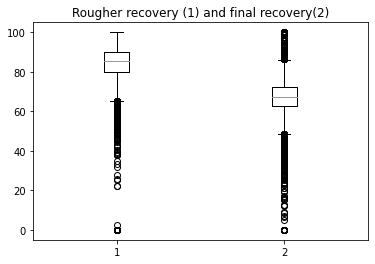

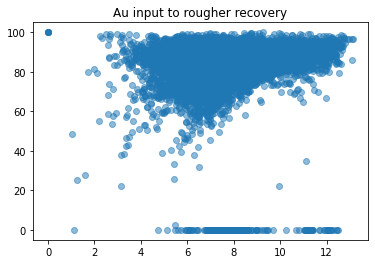

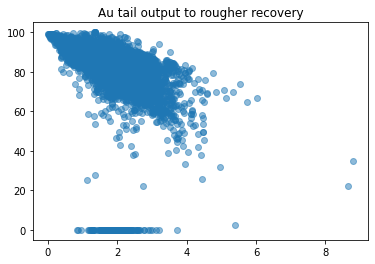

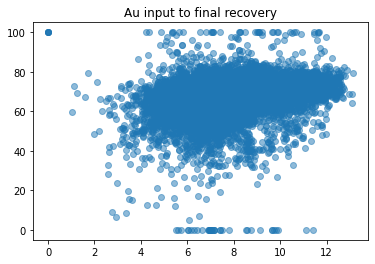

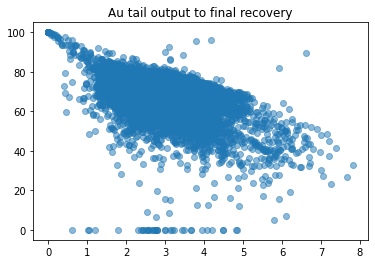

In [13]:
plt.boxplot(data_train[['rougher.output.recovery', 'final.output.recovery']])
plt.title('Rougher recovery (1) and final recovery(2)')
plt.show()


plt.scatter(data_train['rougher.input.feed_au'], data_train['rougher.output.recovery'], alpha=0.5)
plt.title('Au input to rougher recovery')
plt.show()

plt.scatter(data_train['rougher.output.tail_au'], data_train['rougher.output.recovery'], alpha=0.5)
plt.title('Au tail output to rougher recovery')
plt.show()

plt.scatter(data_train['rougher.input.feed_au'], data_train['final.output.recovery'], alpha=0.5)
plt.title('Au input to final recovery')
plt.show()

plt.scatter(data_train['final.output.tail_au'], data_train['final.output.recovery'], alpha=0.5)
plt.title('Au tail output to final recovery')
plt.show()


In [14]:
data_train[[
    'rougher.output.recovery',
    'final.output.recovery',
    'rougher.input.feed_au',
    'rougher.output.concentrate_au',
    'final.output.concentrate_au',
    'rougher.output.tail_au',
    'final.output.tail_au',
    #'recovery_to_input',
]].\
loc[
    (data_train['final.output.recovery'] > 99) |
    (data_train['final.output.recovery'] < 5) |
    (data_train['rougher.output.recovery'] > 99) |
    (data_train['rougher.output.recovery'] < 5)
].\
sort_values(by='final.output.recovery')

,rougher.output.recovery,final.output.recovery,rougher.input.feed_au,rougher.output.concentrate_au,final.output.concentrate_au,rougher.output.tail_au,final.output.tail_au
4966,80.886673,0.000000,8.519387,24.453405,0.000000,2.267259,3.420555
6254,85.325665,0.000000,7.394084,21.343779,0.000000,1.540347,4.489633
2236,69.679278,0.000000,7.390769,21.700017,0.000000,2.938235,3.170143
9320,75.759559,0.000000,5.741317,20.818637,0.000000,1.759284,4.489584
8920,80.716925,0.000000,6.024148,21.565663,0.000000,1.499810,3.485946
8919,76.331765,0.000000,6.145458,21.447548,0.000000,1.861708,3.660732
5784,92.332421,0.000000,11.436133,22.207900,0.000000,1.671744,0.619892
5140,86.903688,0.000000,9.663061,23.927417,0.000000,1.949809,3.115444
5139,87.318224,0.000000,9.641182,23.710651,0.000000,1.895769,2.990722
4724,83.055260,0.000000,6.649982,20.898669,0.000000,1.531597,2.385774


In [15]:
data_train = data_train.drop(
    data_train[
        (data_train['final.output.recovery'] > 99) |
        (data_train['final.output.recovery'] < 5) |
        (data_train['rougher.output.recovery'] > 99) |
        (data_train['rougher.output.recovery'] < 5)
    ].index
)


In [16]:
def recovery(c, f, t):
    "Рассчет эффективности обогащения"
    
    return c * (f - t) / (f * (c - t)) * 100

recovery_rough = data_train.apply(lambda row:
    recovery(
        row['rougher.output.concentrate_au'],
        row['rougher.input.feed_au'],
        row['rougher.output.tail_au']
    ),
    axis=1
)

recovery_final = data_train.apply(lambda row:
    recovery(
        row['final.output.concentrate_au'],
        row['rougher.input.feed_au'],
        row['final.output.tail_au']
    ),
    axis=1
)

print(mean_absolute_error(data_train['rougher.output.recovery'], recovery_rough))
print(mean_absolute_error(data_train['final.output.recovery'], recovery_final))


9.970871232948951e-15
8.643308470886863e-15


## Анализ данных

In [17]:
sample = data_train
for metal in ('au', 'ag', 'pb'):
    print('Concentration {} by stage:'.format(metal.upper()))
    for stage in STAGES:
        for param in ('.input.feed_', '.output.concentrate_'):
            col = stage + param + metal
            try:
                print(col + '{:.1%}'.format(sample[col].mean() / 100).ljust(10).rjust(50 - len(col)))
            except KeyError:
                pass
    print()
    

Concentration AU by stage:
rougher.input.feed_au                   7.9%      
rougher.output.concentrate_au           20.0%     
primary_cleaner.output.concentrate_au   32.5%     
final.output.concentrate_au             44.2%     

Concentration AG by stage:
rougher.input.feed_ag                   8.6%      
rougher.output.concentrate_ag           12.0%     
primary_cleaner.output.concentrate_ag   8.3%      
final.output.concentrate_ag             5.1%      

Concentration PB by stage:
rougher.input.feed_pb                   3.5%      
rougher.output.concentrate_pb           7.9%      
primary_cleaner.output.concentrate_pb   9.6%      
final.output.concentrate_pb             10.2%     



In [18]:
print(data_train['rougher.input.feed_size'].describe())
print(data_test['rougher.input.feed_size'].describe())


count    12365.000000
mean        58.485508
std         20.602668
min          9.659576
25%         48.792180
50%         54.752498
75%         63.731595
max        484.967466
Name: rougher.input.feed_size, dtype: float64
count    5229.000000
mean       55.863978
std        18.914656
min         0.046369
25%        43.911874
50%        50.772729
75%        62.265394
max       392.494040
Name: rougher.input.feed_size, dtype: float64


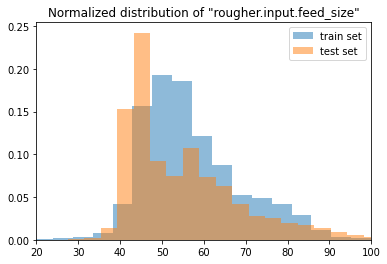

In [19]:
w1 = np.ones_like(data_train['rougher.input.feed_size'])/float(len(data_train['rougher.input.feed_size']))
plt.hist(
    data_train['rougher.input.feed_size'],
    bins=100,
    alpha=0.5,
    weights=w1,
    label='train set',
)

w2 = np.ones_like(data_test['rougher.input.feed_size'])/float(len(data_test['rougher.input.feed_size']))
plt.hist(
    data_test['rougher.input.feed_size'], 
    bins=100, 
    alpha=0.5,
    weights=w2,
    label='test set',
)
plt.title('Normalized distribution of "rougher.input.feed_size"')
plt.xlim(20, 100)
plt.legend()
plt.show();

In [20]:
inds_sampled = data_train['rougher.input.feed_size'].sample(n=1000, axis=0, weights=data_test['rougher.input.feed_size'])

In [21]:
df = data_train[data_train.index.isin(inds_sampled.index)]

In [22]:
data_train['rougher.input.feed_size'].describe()

count    12365.000000
mean        58.485508
std         20.602668
min          9.659576
25%         48.792180
50%         54.752498
75%         63.731595
max        484.967466
Name: rougher.input.feed_size, dtype: float64

In [23]:
coef = 1
min_v = data_test['rougher.input.feed_size'].min()
max_v = data_test['rougher.input.feed_size'].max()
bins = 100
step = (min_v + max_v) / bins
borders = [(min_v + step * i, min_v + step * (i + 1)) for i in range(bins)]
borders_quant = [
    (
        b[0],
        b[1],
        int(coef * 
            len(data_test['rougher.input.feed_size'].loc[(data_test['rougher.input.feed_size'] >= b[0]) &
                                                         (data_test['rougher.input.feed_size'] < b[1])])
        )
    )
    for b in borders
]




In [24]:
q = 0
d_t = pd.DataFrame(columns=data_train.columns)
for i in range(bins):
    df_to_sample = data_train['rougher.input.feed_size'].loc[
        (data_train['rougher.input.feed_size'] >= borders_quant[i][0]) &
        (data_train['rougher.input.feed_size'] < borders_quant[i][1])]
    if len(df_to_sample):
        q += borders_quant[i][2]
        replace = True if q > len(df_to_sample) else False
        inds_sampled = df_to_sample.sample(
            n=borders_quant[i][2],
            replace=replace,
            random_state=RS,
            axis=0,
        )
        d_t = pd.concat(
            [d_t,
            data_train[data_train.index.isin(inds_sampled.index)]],
            axis=0,
            ignore_index=True,
        )
        q = 0
    else:
        q += borders_quant[i][2]


In [25]:
d_t['rougher.input.feed_size'].describe()

count    4764.000000
mean       56.220945
std        15.339611
min        24.791570
25%        46.016100
50%        52.429084
75%        62.827491
max       339.272589
Name: rougher.input.feed_size, dtype: float64

In [26]:
data_test['rougher.input.feed_size'].describe()

count    5229.000000
mean       55.863978
std        18.914656
min         0.046369
25%        43.911874
50%        50.772729
75%        62.265394
max       392.494040
Name: rougher.input.feed_size, dtype: float64

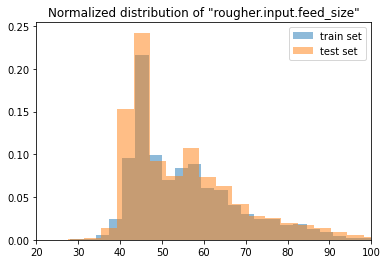

In [29]:
w1 = np.ones_like(d_t['rougher.input.feed_size'])/float(len(d_t['rougher.input.feed_size']))
plt.hist(
    d_t['rougher.input.feed_size'],
    bins=100,
    alpha=0.5,
    weights=w1,
    label='train set',
)

w2 = np.ones_like(data_test['rougher.input.feed_size'])/float(len(data_test['rougher.input.feed_size']))
plt.hist(
    data_test['rougher.input.feed_size'], 
    bins=100, 
    alpha=0.5,
    weights=w2,
    label='test set',
)

plt.title('Normalized distribution of "rougher.input.feed_size"')
plt.xlim(20, 100)
plt.legend()
plt.show();

In [30]:
#  !!!!!!!!!!!!!!!!
# data_train = d_t

In [31]:
sample = data_train
print('Total concentration of substance by stage:')
for stage in STAGES:
    for param in ('.input.feed_', '.output.concentrate_'):
        try:
            concentration = 0
            for substance in SUBSTANCES:
                concentration += sample[stage + param + substance].mean()
            col = stage + param
            print(col + '{:.1%}'.format(concentration / 100).ljust(10).rjust(50 - len(col)))
        except KeyError:
            pass


Total concentration of substance by stage:
rougher.input.feed_                     56.5%     
rougher.output.concentrate_             69.5%     
primary_cleaner.output.concentrate_     60.6%     
final.output.concentrate_               69.3%     


## Модель

In [32]:
def score_smape(y, y_hat, **kwargs):
    return sum([abs(a - b) / ((abs(a) + abs(b)) / 2) for a, b in zip(y, y_hat)]) / len(y)

def smape_total(smape_rougher, smape_final):
    return 0.25 * smape_rougher + 0.75 * smape_final

In [33]:
model_scorer = make_scorer(score_smape, greater_is_better=False)

In [34]:
features = features_final
targets = targets_final
sample=data_train.loc[(data_train['final.output.recovery'] > 0)]
X = sample[features]
y = sample[targets]


In [35]:
'''
for power in ('2'):
    for col in features:
        X[col + power] = X[col] * X[col]
for power in ('3'):
    for col in features:
        X[col + power] = X[col] * X[col] * X[col]
'''


"\nfor power in ('2'):\n    for col in features:\n        X[col + power] = X[col] * X[col]\nfor power in ('3'):\n    for col in features:\n        X[col + power] = X[col] * X[col] * X[col]\n"

In [36]:
best_models_final = []

for name, estimator, parameters in REGRESSORS:
    print(name)

    model = GridSearchCV(
        estimator=estimator(),
        cv=4,
        param_grid=parameters,
        scoring=model_scorer,
    )
    model.fit(X, y.values.ravel())
    best_models_final.append((name, model.best_estimator_, model.best_score_))

Linear Regression
Lasso
Dummy Regressor


Linear Regression
sMAPE score:                            8.6%      
r2 score:                               38.7%     
corr coef between error and y-actual:   78.3%     


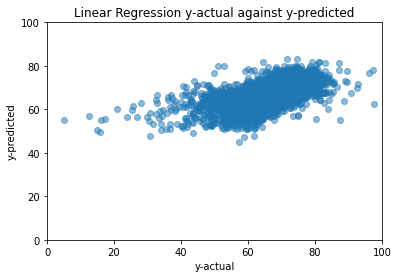

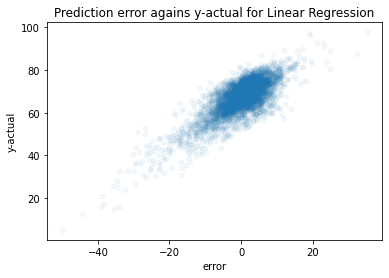


Lasso
sMAPE score:                            8.3%      
r2 score:                               33.9%     
corr coef between error and y-actual:   83.8%     


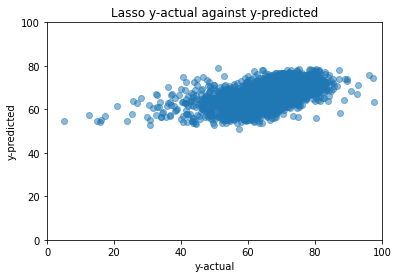

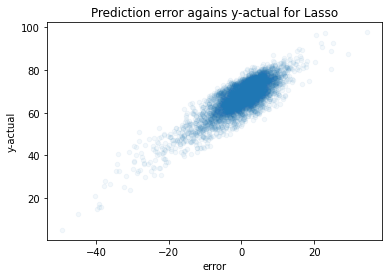


Dummy Regressor
sMAPE score:                            9.5%      
r2 score:                               -1.4%     
corr coef between error and y-actual:   100.0%    


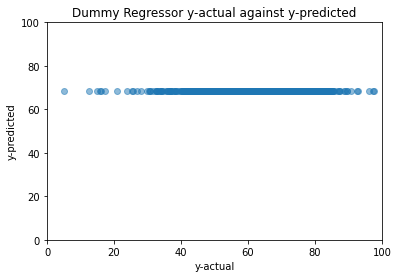

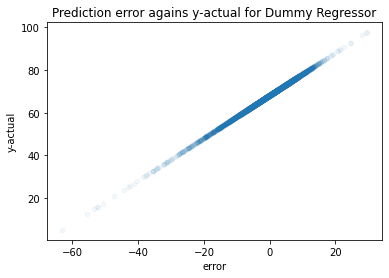

In [37]:
for name, model, score in best_models_final:
    y_predict = model.predict(X)
    plot_df = pd.DataFrame(y.to_numpy().ravel(), (y.to_numpy().ravel() - y_predict.ravel())).reset_index()
    print(name)
    for metric_name, metric_score in (
        ('sMAPE score:', -score),
        ('r2 score:', r2_score(y, y_predict)),
        ('corr coef between error and y-actual:', plot_df.corr().iloc[0][0]),
    ):
        print(metric_name + '{:.1%}'.format(metric_score).ljust(10).rjust(50 - len(metric_name)))
   
    plt.scatter(x=y, y=y_predict, alpha=0.5)
    plt.title(name +' y-actual against y-predicted')
    plt.xlabel('y-actual')
    plt.ylabel('y-predicted')
    plt.xlim(0, 100)
    plt.ylim(0, 100)
    plt.show()
    
    plot_df.plot(x='index', y=0, kind='scatter', alpha=0.05);
    plt.title('Prediction error agains y-actual for ' + name)
    plt.xlabel('error')
    plt.ylabel('y-actual')
    plt.show()
    
    print()

In [38]:
features = features_rougher
targets = targets_rougher
sample=data_train.loc[(data_train['final.output.recovery'] > 0)]
X = sample[features]
y = sample[targets]


In [39]:
best_models_rougher = []

for name, estimator, parameters in REGRESSORS:
    print(name)

    model = GridSearchCV(
        estimator=estimator(),
        cv=4,
        param_grid=parameters,
        scoring=model_scorer,
    )
    model.fit(X, y.values.ravel())
    best_models_rougher.append((name, model.best_estimator_, model.best_score_))

Linear Regression
Lasso
Dummy Regressor


Linear Regression
sMAPE score:                            6.0%      
r2 score:                               52.3%     
corr coef between error and y-actual:   69.1%     


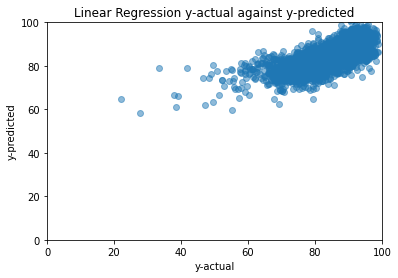

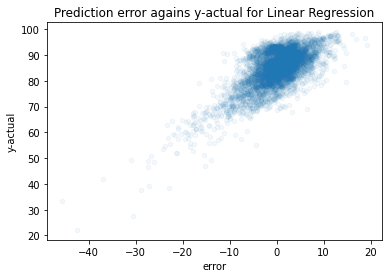


Lasso
sMAPE score:                            6.3%      
r2 score:                               45.8%     
corr coef between error and y-actual:   78.3%     


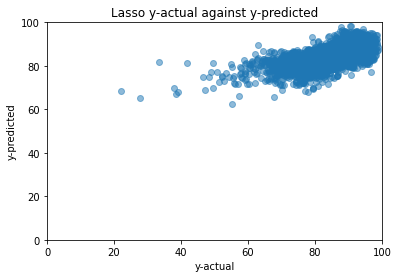

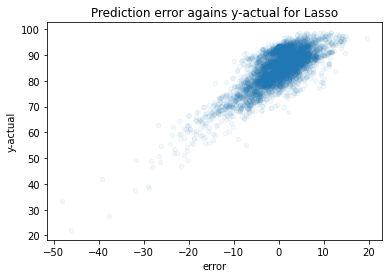


Dummy Regressor
sMAPE score:                            7.3%      
r2 score:                               -2.8%     
corr coef between error and y-actual:   100.0%    


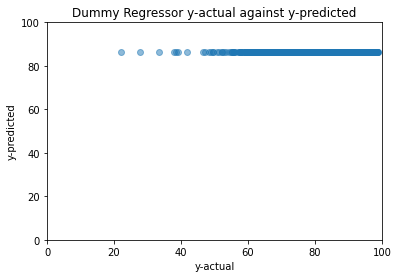

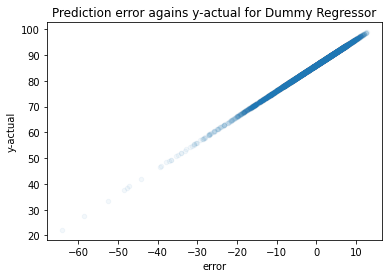

In [40]:
for name, model, score in best_models_rougher:
    y_predict = model.predict(X)
    plot_df = pd.DataFrame(y.to_numpy().ravel(), (y.to_numpy().ravel() - y_predict.ravel())).reset_index()
    print(name)
    for metric_name, metric_score in (
        ('sMAPE score:', -score),
        ('r2 score:', r2_score(y, y_predict)),
        ('corr coef between error and y-actual:', plot_df.corr().iloc[0][0]),
    ):
        print(metric_name + '{:.1%}'.format(metric_score).ljust(10).rjust(50 - len(metric_name)))
   
    plt.scatter(x=y, y=y_predict, alpha=0.5)
    plt.title(name +' y-actual against y-predicted')
    plt.xlabel('y-actual')
    plt.ylabel('y-predicted')
    plt.xlim(0, 100)
    plt.ylim(0, 100)
    plt.show()
    
    plot_df.plot(x='index', y=0, kind='scatter', alpha=0.05);
    plt.title('Prediction error agains y-actual for ' + name)
    plt.xlabel('error')
    plt.ylabel('y-actual')
    plt.show()
    
    print()

In [41]:
print('Total sMAPE score by model:')
for (name, _, score_rougher), (_, _, score_final) in zip(best_models_rougher, best_models_final):
    print(
        name+ '{:.1%}'.format(
            -smape_total(score_rougher, score_final)
        ).ljust(10).rjust(30 - len(name))
    )

Total sMAPE score by model:
Linear Regression   7.9%      
Lasso               7.8%      
Dummy Regressor     9.0%      


#### Прогноз с лучшей моделью

In [42]:
data_test_new = data_test.merge(data_initial[['date', 'final.output.recovery', 'rougher.output.recovery']], on='date')

In [43]:
'''
data_test_new = data_test_new.drop(
    data_test_new[
        (data_test_new['final.output.recovery'] > 99) |
        (data_test_new['final.output.recovery'] < 5) |
        (data_test_new['rougher.output.recovery'] > 99) |
        (data_test_new['rougher.output.recovery'] < 5)
    ].index
)
'''

"\ndata_test_new = data_test_new.drop(\n    data_test_new[\n        (data_test_new['final.output.recovery'] > 99) |\n        (data_test_new['final.output.recovery'] < 5) |\n        (data_test_new['rougher.output.recovery'] > 99) |\n        (data_test_new['rougher.output.recovery'] < 5)\n    ].index\n)\n"

In [44]:
total_score = dict()

In [45]:
features = features_rougher
targets = targets_rougher
X = data_test_new[features]
y = data_test_new[targets]

Lasso
sMAPE score:                            7.5%      
r2 score:                               4.4%      
corr coef between error and y-actual:   94.9%     


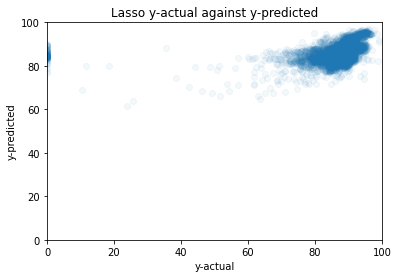

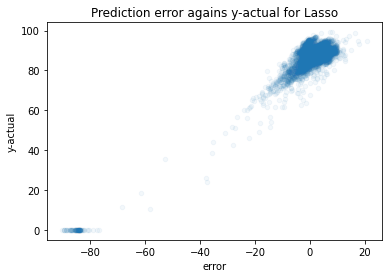


Dummy Regressor
sMAPE score:                            8.2%      
r2 score:                               -0.7%     
corr coef between error and y-actual:   100.0%    


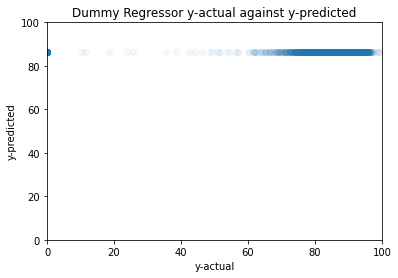

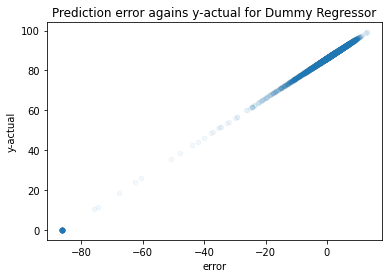

In [46]:

for name, model, score in [best_models_rougher[1], best_models_rougher[-1]]:
    score = -score_smape(y.to_numpy().ravel(), y_predict.ravel())
    y_predict = model.predict(X)
    plot_df = pd.DataFrame(y.to_numpy().ravel(), (y.to_numpy().ravel() - y_predict.ravel())).reset_index()
    print(name)
    for metric_name, metric_score in (
        ('sMAPE score:', -score),
        ('r2 score:', r2_score(y, y_predict)),
        ('corr coef between error and y-actual:', plot_df.corr().iloc[0][0]),
    ):
        print(metric_name + '{:.1%}'.format(metric_score).ljust(10).rjust(50 - len(metric_name)))

    plt.scatter(x=y, y=y_predict, alpha=0.05)
    plt.title(name +' y-actual against y-predicted')
    plt.xlabel('y-actual')
    plt.ylabel('y-predicted')
    plt.xlim(0, 100)
    plt.ylim(0, 100)
    plt.show()

    plot_df.plot(x='index', y=0, kind='scatter', alpha=0.05);
    plt.title('Prediction error agains y-actual for ' + name)
    plt.xlabel('error')
    plt.ylabel('y-actual')
    plt.show()
    
    total_score[name] = [score] if not total_score.get(name) else total_score[name] + [score]
    print()

In [47]:
features = features_final
targets = targets_final
X = data_test_new[features]
y = data_test_new[targets]

Lasso
sMAPE score:                            9.1%      
r2 score:                               -0.6%     
corr coef between error and y-actual:   85.5%     


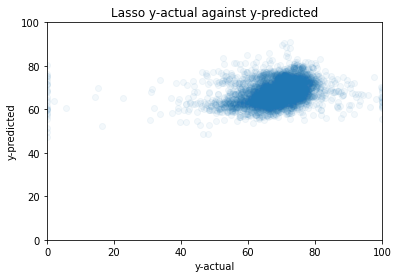

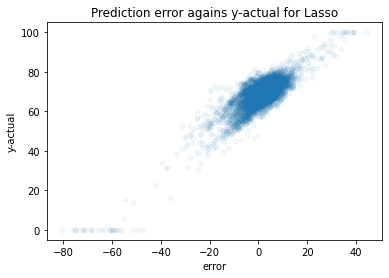


Dummy Regressor
sMAPE score:                            8.9%      
r2 score:                               -0.2%     
corr coef between error and y-actual:   100.0%    


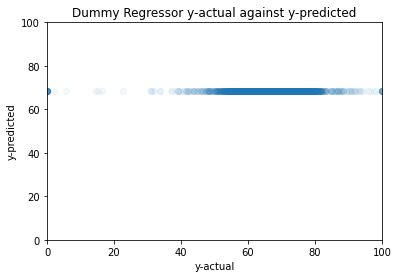

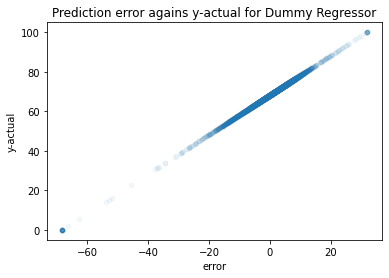

In [48]:
for name, model, score in [best_models_final[1], best_models_final[-1]]:
    y_predict = model.predict(X)
    score = -score_smape(y.to_numpy().ravel(), y_predict.ravel())
    plot_df = pd.DataFrame(y.to_numpy().ravel(), (y.to_numpy().ravel() - y_predict.ravel())).reset_index()
    print(name)
    for metric_name, metric_score in (
        ('sMAPE score:', -score),
        ('r2 score:', r2_score(y, y_predict)),
        ('corr coef between error and y-actual:', plot_df.corr().iloc[0][0]),
    ):
        print(metric_name + '{:.1%}'.format(metric_score).ljust(10).rjust(50 - len(metric_name)))
   
    plt.scatter(x=y, y=y_predict, alpha=0.05)
    plt.title(name +' y-actual against y-predicted')
    plt.xlabel('y-actual')
    plt.ylabel('y-predicted')
    plt.xlim(0, 100)
    plt.ylim(0, 100)
    plt.show()
    
    plot_df.plot(x='index', y=0, kind='scatter', alpha=0.05);
    plt.title('Prediction error agains y-actual for ' + name)
    plt.xlabel('error')
    plt.ylabel('y-actual')
    plt.show()
    
    total_score[name] = [score] if not total_score.get(name) else total_score[name] + [score] 
    print()

In [49]:
for name, value in total_score.items():
    print(name + '{:.2%}'.format(-smape_total(value[0], value[1])).ljust(10).rjust(30 - len(name)))

Lasso               8.67%     
Dummy Regressor     8.74%     


## Чек-лист готовности проекта

- [x]  Jupyter Notebook открыт
- [ ]  Весь код выполняется без ошибок
- [ ]  Ячейки с кодом расположены в порядке выполнения
- [ ]  Выполнен шаг 1: данные подготовлены
    - [ ]  Проверена формула вычисления эффективности обогащения
    - [ ]  Проанализированы признаки, недоступные в тестовой выборке
    - [ ]  Проведена предобработка данных
- [ ]  Выполнен шаг 2: данные проанализированы
    - [ ]  Исследовано изменение концентрации элементов на каждом этапе
    - [ ]  Проанализированы распределения размеров гранул на обучающей и тестовой выборках
    - [ ]  Исследованы суммарные концентрации
- [ ]  Выполнен шаг 3: построена модель прогнозирования
    - [ ]  Написана функция для вычисления итогового *sMAPE*
    - [ ]  Обучено и проверено несколько моделей
    - [ ]  Выбрана лучшая модель, её качество проверено на тестовой выборке